In [1]:
sys.path.insert(
    0, "/Users/jin/Programming/Machine_Learning/All-about-Market/trading/Jeong/machine_trade/code")
from sklearn.preprocessing import MinMaxScaler
from functools import reduce
from DataBaseControl import DataBaseControl
import transform_feature
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import sys
import model



</b>기술적 지표 선택 기준</b>
* 피쳐는 기본적인 ohlcv와 더불어 대표적으로 사용되는 기술적 지표들은 OBV, RSI, MACD, Stochastic, William 지표를 활용했다.
* 피쳐 선택 또한 신중히 해야하나 금융 쪽 도메인에 대한 명확한 이해가 없어 각종 논문이나 서적에서 자주 참고하는 지표를 채택했다.
* https://github.com/areed1192/sigma_coding_youtube/blob/master/python/python-data-science/machine-learning/random-forest/random_forest_price_prediction.ipynb (해당 노트북으로 부터 많은 아이디어를 참고했다.)

In [2]:

db_control = DataBaseControl("raw")
bit = db_control.get_df("*",table_name="BTCUSD_1d")
bit = bit.loc[~bit.index.duplicated()]
bit.dropna(inplace=True)
bit.drop_duplicates(inplace=True)
transformer = transform_feature.FeatureTransformer(
    adj_close=bit['Adj Close'], high=bit['High'], low=bit['Low'], volume=bit['Volume'])
transformer.transform(bit, is_coin=True)
bit


Create new feature complete


,Open,High,Low,Close,Adj Close,Volume,Rsi,Moment,Pct_change,OBV,William
Date,,,,,,,,,,,
2015-02-10,220.281998,221.807007,215.332001,219.839005,219.839005,21115100,42.597041,0.827181,-3.142676,-155617504,-67.587762
2015-02-11,219.731995,223.406006,218.074005,219.184998,219.184998,17201900,42.330900,0.823603,-7.993992,-172819404,-78.517210
2015-02-12,219.207993,222.199005,217.613998,221.764008,221.764008,15206200,43.821488,0.828948,-2.421809,-157613204,-76.272211
2015-02-13,221.968994,240.259003,221.261993,235.427002,235.427002,42744400,51.041239,0.859644,3.779542,-114868804,-64.378730
2015-02-14,235.528000,259.808014,235.528000,257.321014,257.321014,49732500,59.928230,0.908610,18.520491,-65136304,-49.949619
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-05,20225.353516,20635.466797,19341.232422,20190.115234,20190.115234,26715546990,36.785603,32.221877,-3.981395,1575430423164,-80.764652
2022-07-06,20194.619141,20595.529297,19823.511719,20548.246094,20548.246094,24598943708,39.723985,32.298974,-0.902957,1600029366872,-77.350395
2022-07-07,20547.814453,21771.816406,20296.103516,21637.587891,21637.587891,25814972520,47.689093,32.387599,6.690881,1625844339392,-66.399843


<b>비트코인 데이터 이외</b>
* 비트코인 가격만으로 학습을 시킬 경우 외부 상황이나 경제적 이슈에 대응하지 못할 수 있기에 대표적인 경제 지표들은 학습 가능하게 추가해뒀다.
* 비트코인 가격이외 추가적으로 사용하는 피쳐는 나스닥 etf인 qqq, 미국 10년물 국채 금리, 금 선물 가격, 달러 인덱스, VIX 지수이다.


In [3]:
vix = db_control.get_df("Date", "Close", table_name="VIX_1d")
usd = db_control.get_df("Date", "Close", table_name="DXF_1d")
tnx = db_control.get_df("Date", "Close", table_name="TNX_1d")
gld = db_control.get_df("Date", "Close", table_name="GCF_1d")
qqq = db_control.get_df("Date", "Close", table_name="QQQ_1d")
ovx = db_control.get_df("Date", "Close", table_name="OVX_1d")

data_frames = [bit, vix, usd, tnx, qqq, gld, ovx]
for df, ticker in zip(data_frames[1:], ["VIX", "USD", "TNX", "QQQ", "GOLD", "OVX"]):
    df.columns = [f"{ticker}_{c}" for c in df.columns]


In [4]:
df = reduce(lambda left, right: left.join(right), data_frames)
df


,Open,High,Low,Close,Adj Close,Volume,Rsi,Moment,Pct_change,OBV,William,VIX_Close,USD_Close,TNX_Close,QQQ_Close,GOLD_Close,OVX_Close
Date,,,,,,,,,,,,,,,,,
2015-02-10,220.281998,221.807007,215.332001,219.839005,219.839005,21115100,42.597041,0.827181,-3.142676,-155617504,-67.587762,NaN,NaN,NaN,104.400002,NaN,NaN
2015-02-11,219.731995,223.406006,218.074005,219.184998,219.184998,17201900,42.330900,0.823603,-7.993992,-172819404,-78.517210,NaN,NaN,NaN,104.779999,NaN,NaN
2015-02-12,219.207993,222.199005,217.613998,221.764008,221.764008,15206200,43.821488,0.828948,-2.421809,-157613204,-76.272211,NaN,NaN,NaN,106.000000,NaN,NaN
2015-02-13,221.968994,240.259003,221.261993,235.427002,235.427002,42744400,51.041239,0.859644,3.779542,-114868804,-64.378730,NaN,NaN,NaN,106.910004,NaN,NaN
2015-02-14,235.528000,259.808014,235.528000,257.321014,257.321014,49732500,59.928230,0.908610,18.520491,-65136304,-49.949619,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-05,20225.353516,20635.466797,19341.232422,20190.115234,20190.115234,26715546990,36.785603,32.221877,-3.981395,1575430423164,-80.764652,27.540001,106.320000,2.809,286.959991,1761.800049,52.610001
2022-07-06,20194.619141,20595.529297,19823.511719,20548.246094,20548.246094,24598943708,39.723985,32.298974,-0.902957,1600029366872,-77.350395,26.730000,106.898003,2.913,288.799988,1734.900024,54.669998
2022-07-07,20547.814453,21771.816406,20296.103516,21637.587891,21637.587891,25814972520,47.689093,32.387599,6.690881,1625844339392,-66.399843,26.080000,106.959000,3.008,294.980011,1737.900024,52.869999


In [5]:
new_df = df.loc[~df.index.duplicated()]
new_df = new_df.ffill()
new_df['Target'] = np.sign(new_df['Adj Close'].diff()).shift(-1)
new_df.dropna(inplace=True)
new_df


,Open,High,Low,Close,Adj Close,Volume,Rsi,Moment,Pct_change,OBV,William,VIX_Close,USD_Close,TNX_Close,QQQ_Close,GOLD_Close,OVX_Close,Target
Date,,,,,,,,,,,,,,,,,,
2015-02-27,236.436005,256.653015,236.436005,253.828003,253.828003,44013900,58.602115,0.924069,7.405871,-91677804,-21.984833,13.340000,95.320999,2.002,108.400002,1212.599976,55.849998,1.0
2015-02-28,253.520004,254.692001,249.479004,254.263000,254.263000,13949300,58.802083,0.921736,5.818138,-77728504,-22.300819,13.340000,95.320999,2.002,108.400002,1212.599976,55.849998,1.0
2015-03-01,254.283005,261.660004,245.932999,260.201996,260.201996,25213700,61.534015,0.934267,6.736835,-52514804,-10.629639,13.340000,95.320999,2.002,108.400002,1212.599976,55.849998,1.0
2015-03-02,260.356995,276.300995,258.312988,275.670013,275.670013,40465700,67.566482,0.968223,12.732797,-12049104,-1.024720,13.040000,95.478996,2.084,109.379997,1207.699951,54.919998,1.0
2015-03-03,275.045990,285.795990,268.161011,281.701996,281.701996,50461300,69.570593,0.980679,19.376884,38412196,-5.760430,13.860000,95.407997,2.122,108.870003,1204.000000,53.049999,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-04,19297.314453,20258.748047,19063.066406,20231.261719,20231.261719,21594638208,36.977918,32.274729,-5.911339,1602145970154,-81.375962,26.700001,104.908997,2.889,282.130005,1798.900024,49.400002,-1.0
2022-07-05,20225.353516,20635.466797,19341.232422,20190.115234,20190.115234,26715546990,36.785603,32.221877,-3.981395,1575430423164,-80.764652,27.540001,106.320000,2.809,286.959991,1761.800049,52.610001,1.0
2022-07-06,20194.619141,20595.529297,19823.511719,20548.246094,20548.246094,24598943708,39.723985,32.298974,-0.902957,1600029366872,-77.350395,26.730000,106.898003,2.913,288.799988,1734.900024,54.669998,1.0


<b>최종 데이터 설명</b>
* 모델 학습을 위한 데이터는 2015.02.10~2022.05.07까지 약 7년 간 1일 간격의 데이터이다.
* 주식이나 금리 데이터 등의 경우 주말 데이터가 존재하지 않아 데이터의 수가 더 적어야 하지만,
부족한 데이터 수를 매워보고자 금요일의 데이터를 복사해 넣는 방식으로 데이터를 구성했다.
* 결측치나 중복이 발생한 데이터를 제외하고 총 데이터는 2626개로 구성된다.

<b>모델 설명</b>
* 모델은 랜덤 포레스트 분류기를 사용할 것이며 모델이 예측하는 값은 내일 비트코인이 상승인지 하락인지이다.
* 랜덤 포레스트를 사용한 까닭과 회귀를 통한 가격 예측이 아닌 분류를 사용한 이유는 정확도 때문이다.
* 모델의 학습 방식은 다음과 같다.
    * 모델은 120일 단위로 학습을 진행한다. 
    * 모델의 학습은 매일 이뤄지며 오늘까지의 총 120일간의 데이터로 다음날 방향성을 예측한다.

In [19]:
X = new_df.drop(['Target'], axis=1)
y = new_df['Target'].values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)


In [46]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
param_grid = [
        {'max_depth':[100,200],
        'min_samples_leaf':[2,4,8,16],
        'min_samples_split':[2, 5, 10, 20]
        }
    ]

def get_feature_importance(model_):
    feature_imp = pd.DataFrame(data=model_.feature_importances_).T
    return feature_imp

def get_gridcv(model, param_grid, score = "accuracy"):
    time_cv = TimeSeriesSplit(n_splits=4)
    grid_model = GridSearchCV(estimator=model, scoring=score, param_grid=param_grid,
                            cv=time_cv, n_jobs=-1, verbose=3)
    return grid_model

def get_report(target, pred):
    cls_report = classification_report(target, pred, output_dict=True, target_names=[
                                        "up", "down"], labels=[1, -1])
    report_df = pd.DataFrame([cls_report["down"], cls_report["up"]])
    return report_df

In [101]:
SIZE = 120
feature_res = pd.DataFrame()
pred = []
f1_res = pd.DataFrame()
total_pred = []
best_params = {}
end_index = len(new_df) - SIZE - 1 #예측을 위한 한계 인덱스
# end_index = 20

for i in range(end_index):
    train_X = X[i: i + SIZE]
    train_y = y[i: i + SIZE]

    test_X = X[i + SIZE]
    test_y = y[i + SIZE]

    rf_model = RandomForestClassifier(**best_params)
    rf_model.fit(train_X, train_y)

    pred_value = rf_model.predict([test_X])
    pred.append(*pred_value)

    total_pred.append(*pred_value)
    
    if len(pred) == SIZE:
        grid_cv = get_gridcv(rf_model, param_grid)
        grid_cv.fit(train_X, train_y)
        best_params = grid_cv.best_params_

        f1_res = f1_res.append(get_report(train_y, pred))
        feature_res = feature_res.append(get_feature_importance(rf_model))
        pred = []   


Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    6.5s finished


Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.6s finished


Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.1s finished


Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.0s finished


Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.1s finished


Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.0s finished


Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.1s finished


Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.1s finished


Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.1s finished


Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.2s finished


Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.2s finished


Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.2s finished


Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.3s finished


Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.2s finished


Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.3s finished


Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.3s finished


Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.4s finished


Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.3s finished


Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.3s finished


Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.4s finished


Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    2.5s finished


In [102]:
f1_res.reset_index(inplace=True)
f1_res.rename(columns={'index':'class'}, inplace=True)
f1_res

,class,precision,recall,f1-score,support
0,0,0.568966,0.532258,0.550000,62
1,1,0.532258,0.568966,0.550000,58
2,0,0.703704,0.593750,0.644068,64
3,1,0.606061,0.714286,0.655738,56
4,0,0.707865,0.797468,0.750000,79
5,1,0.483871,0.365854,0.416667,41
6,0,0.513158,0.672414,0.582090,58
7,1,0.568182,0.403226,0.471698,62
8,0,0.679612,0.886076,0.769231,79
9,1,0.470588,0.195122,0.275862,41


In [106]:
f1_res[f1_res['class'] == 1].mean()


class         1.000000
precision     0.576101
recall        0.420984
f1-score      0.469588
support      54.523810
dtype: float64

In [107]:
f1_res[f1_res['class'] == 0].mean()

class         0.000000
precision     0.606645
recall        0.728656
f1-score      0.657459
support      65.428571
dtype: float64

Text(0.5, 1.0, 'Random Forest: Feature Importance Graph')

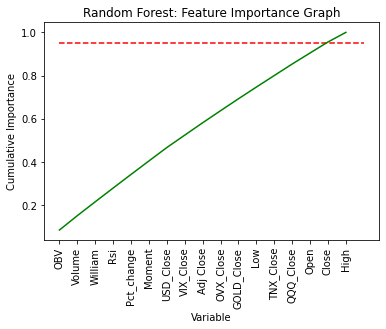

In [113]:
# Cumulative importances
feature_res.columns = new_df.drop(columns = "Target").columns
cumulative_importances = feature_res.mean().sort_values(ascending=False).cumsum()

# Make a line graph
plt.plot(cumulative_importances, 'g-')

# # Draw line at 95% of importance retained
plt.hlines(y=0.95, xmin=0, xmax=len(cumulative_importances),
           color='r', linestyles='dashed')

# # Format x ticks and labels
plt.xticks(rotation='vertical')

# # Axis labels and title
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance')
plt.title('Random Forest: Feature Importance Graph')


In [115]:
feature_res.describe()

,Open,High,Low,Close,Adj Close,Volume,Rsi,Moment,Pct_change,OBV,William,VIX_Close,USD_Close,TNX_Close,QQQ_Close,GOLD_Close,OVX_Close
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,0.051257,0.044537,0.054255,0.050961,0.057196,0.066553,0.063713,0.062595,0.062993,0.084117,0.064353,0.057561,0.062049,0.053415,0.053252,0.055279,0.055913
std,0.016179,0.013111,0.018698,0.018877,0.018418,0.022697,0.019496,0.023701,0.026223,0.030537,0.020230,0.019797,0.030550,0.024700,0.013074,0.022902,0.016036
min,0.026250,0.018515,0.019265,0.021338,0.028145,0.031361,0.031545,0.021993,0.022065,0.049704,0.034948,0.022673,0.019481,0.011552,0.021936,0.028155,0.033061
25%,0.035929,0.036433,0.043485,0.040631,0.047417,0.046553,0.051486,0.047487,0.050219,0.061873,0.052272,0.044127,0.039233,0.040887,0.044923,0.043469,0.043971
50%,0.053850,0.044247,0.052100,0.047681,0.054841,0.062803,0.061940,0.057263,0.061239,0.071408,0.061963,0.052909,0.061120,0.047108,0.057610,0.049816,0.050568
75%,0.062390,0.055799,0.061967,0.064586,0.060857,0.082555,0.072952,0.071191,0.074408,0.096745,0.069191,0.074188,0.075825,0.065145,0.062042,0.056306,0.064826
max,0.084706,0.067089,0.097763,0.097273,0.122880,0.116207,0.102867,0.117587,0.126893,0.160225,0.122027,0.092209,0.156524,0.105266,0.075324,0.120410,0.094877


<b>결과 설명</b>
* 모델의 정확도 자체는 준수한 편이다. 평균적인 f1_score는 0.6정도이다.
* 피쳐는 볼륨(거래량)과 연관된 지표에 크게 영향을 받는다.
* 비트코인이 아닌 지표들 중에는 미국 달러와 금이 영향을 크게 미치는 요소이다.


In [122]:
date_index = new_df.index[SIZE: -1]
pred_series = pd.Series(index=date_index, data=total_pred)
target = y[SIZE: -1]


In [123]:
pred_series.to_csv("pred.csv")

In [130]:
def get_trade_point(pred):
    long_point = []
    short_point = []
    for date, value in pred.items():
        # if value * before < 0:
        if value > 0:
            long_point.append(date)
        else:
            short_point.append(date)
        # before = value

    return long_point, short_point


def day_trade_profit(in_point, is_short=False):
    """ 예측 데이터와 실제 가격의 증감률의 차이에 따라 투자 조건을 다르게 했을 때의
    달라지는 수익률 곡선을 구해준다.
    """
    out_point = [new_df.index.get_loc(p) + 1 for p in in_point]
    price = new_df['Adj Close']
    if out_point[-1] >= len(new_df):
        out_point = out_point[:-1]
        in_point = in_point[:-1]

    if is_short:
        profit = (price.loc[in_point].values -
                price.iloc[out_point].values).cumsum()
    else:
        profit = (price.iloc[out_point].values -
                price.loc[in_point].values).cumsum()
    return profit

# target_long_point, target_short_point = get_trade_point(target)


In [127]:
def plot_point(long_point, short_point):
    out_value = new_df['Adj Close'].loc[short_point]
    in_value = new_df['Adj Close'].loc[long_point]
    plt.figure(figsize=(16, 10))
    plt.plot(df['Adj Close'])
    plt.scatter(x=short_point, y=out_value, c='b')
    plt.scatter(x=long_point, y=in_value, c='r')


(777.7570190429688, 19497.400390625)

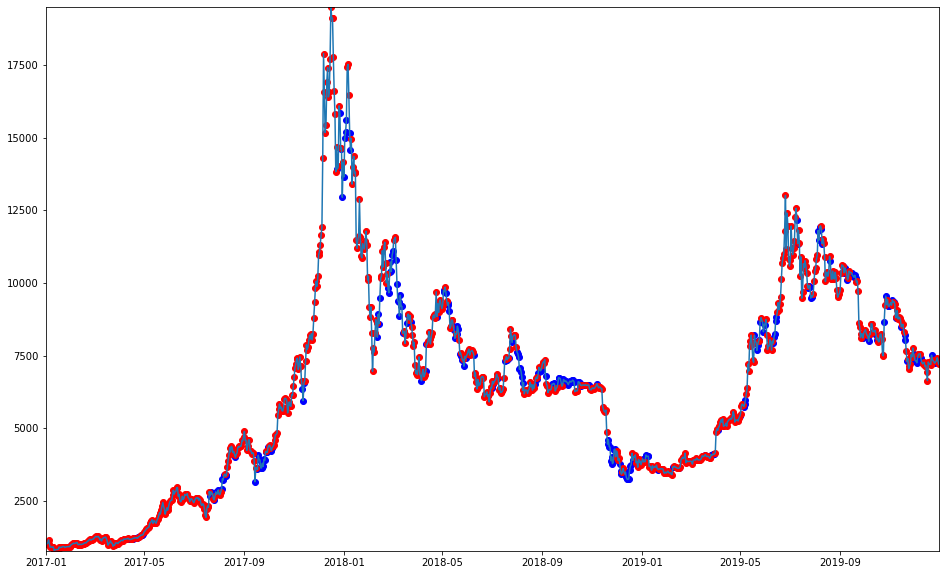

In [151]:
start_day, end_day = ("2017-01-01", "2019-12-31")
min_val, max_val = new_df.loc[start_day:end_day,'Adj Close'].min(), new_df.loc[start_day:end_day,'Adj Close'].max()
long_point, short_point = get_trade_point(pred_series[start_day: end_day])
plot_point(long_point, short_point)
plt.xlim(start_day, end_day)
plt.ylim(min_val, max_val)


<b>단순한 매매로직</b>
* 단순하게 모델이 상승을 예측한 날에 매수를 하고 다음날 바로 매도하는 로직으로 매매를 진행해보자.
* 수익률은 일정 구간동안 괜찮은 모습을 보이다. 특정 기간에 크게 하락하는 모습을 보인다.
* 하락장에서 잘 대응하지 못하는 듯 보인다.

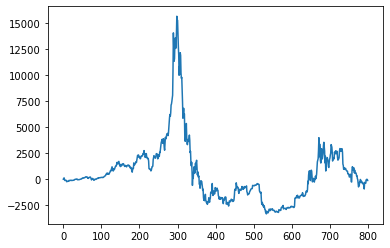

In [152]:
plt.plot(day_trade_profit(long_point))


<AxesSubplot:xlabel='Date'>

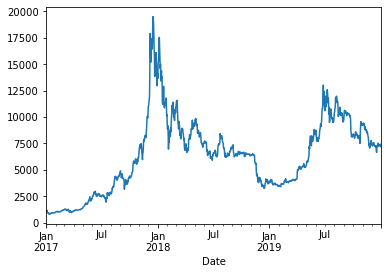

In [153]:
new_df.loc[start_day : end_day,'Adj Close'].plot()


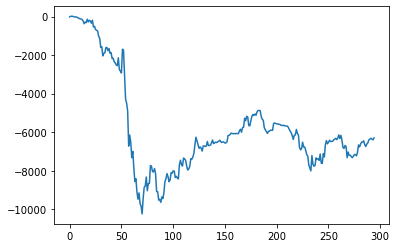

In [154]:
plt.plot(day_trade_profit(short_point, is_short=True))


모델 예측 값과 MACD 아이디어의 조합
* 모델 예측 값을 하루 단위로 사용하면 문제가 많다.
* 모델 예측 값을 이동평균으로 변환해 평균적인 수치를 활용해보자.
* MACD의 아이디어를 모델 예측 값에 그대로 적용했다. 
    * 다만 주식보다 변환이 극심하다는 점을 고려해 MACD의 주기를 절반으로 설정했다.


In [136]:
exp_short = pred_series.ewm(span=6, adjust=False).mean()
exp_long = pred_series.ewm(span=13, adjust=False).mean()
ewm = new_df['Adj Close'].ewm(span=100, adjust=False).mean()
macd = exp_short - exp_long
signal = macd.ewm(span=5, adjust=False).mean()
osi = macd - signal


(array(17167.), array(18261.))

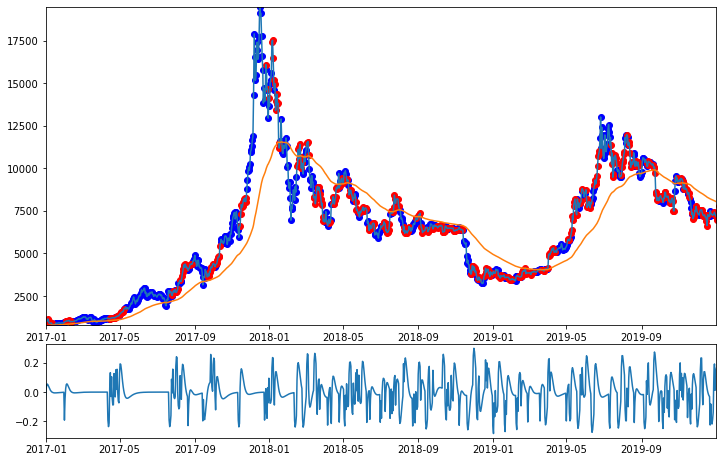

In [156]:
long_point = osi[osi > 0].index
short_point = osi[osi < 0].index
out_value = new_df['Adj Close'].loc[short_point]
in_value = new_df['Adj Close'].loc[long_point]


fig = plt.figure(figsize=(12, 10))

ax_main = plt.subplot2grid((5, 1), (0, 0), rowspan=3)
ax_sub = plt.subplot2grid((5, 1), (3, 0))

ax_main.plot(df['Adj Close'])
ax_main.scatter(x=short_point, y=out_value, c='b')
ax_main.scatter(x=long_point, y=in_value, c='r')
ax_main.set_xlim(start_day, end_day)
ax_main.set_ylim(min_val, max_val)
ax_main.plot(ewm)

ax_sub.plot(osi)
ax_sub.set_xlim(start_day, end_day)



macd 전략을 시도했을 때 수익률을 구해보자.
* stop loss = -3%. profit border = 5%
* 손절라인이나 익절라인에 미치지 않으면 매도를 하지 않는다.
* 익절라인에서 시그널이 재 발생하면 홀드를 하고 손,익절 경계를 다시 설정한다.

In [141]:
profit = {}
up, bottom = (0, 0)
entry_price = 0
#osi, ewm이 전부 존재하는 날짜만 추출
macd_df = new_df.loc[ewm.index.intersection(osi.index)]
prices = macd_df['Adj Close']
sell_pct =  lambda x: (x - entry_price) / entry_price + 1

in_day = []
out_day = []
# high = 0

for day, p in prices.items():
    if entry_price:
        if bottom >= p:
            profit[day] = (sell_pct(p))
            out_day.append(day)
            entry_price = 0
            
        elif p >= up:
            if p > ewm[day] and osi[day] > 0:
                in_day.append(day)
                up, bottom = p * 1.02, p
            else:
                profit[day] = (sell_pct(p))
                out_day.append(day)
                entry_price = 0
    else:
        if p > ewm[day] and osi[day] > 0:
            in_day.append(day)
            up, bottom = p * 1.05, p * 0.97
            entry_price = p


모델의 예측 값과 MACD 전략을 복수로 활용해 사용할 경우 수익률 그래프는 다음과 같다.

<AxesSubplot:>

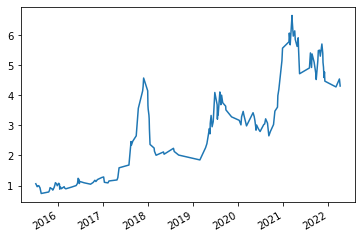

In [157]:
profit = pd.Series(profit)
res = profit.cumprod()
res.plot()


In [143]:
p_std = res.std()
sharpe = (res[-1] - 0.21) / p_std
sharpe


2.5007674818592016